In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split

In [2]:
# Configuración inicial para las gráficas
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar el master_df
try:
    df_master = pd.read_csv('01_data/output/master_df.csv')
    print("Dataset Maestro cargado exitosamente.")
except FileNotFoundError:
    print("ERROR: Asegúrate de que master_df.csv exista en '01_data/output/' y que la ruta sea correcta.")
    raise

Dataset Maestro cargado exitosamente.


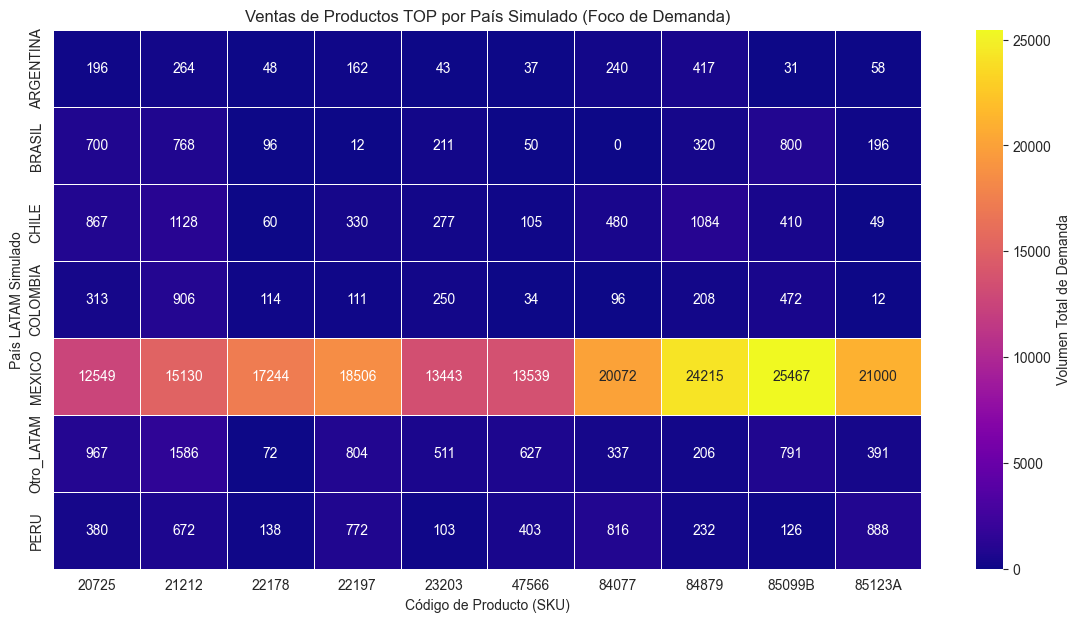

In [3]:
# A. Preparación de datos (Top 10 productos más vendidos)
top_10_stocks = df_master.groupby('StockCode')['Total_Quantity_Sold'].sum().nlargest(10).index
df_heatmap = df_master[df_master['StockCode'].isin(top_10_stocks)]

# B. Pivoteo: País vs Producto
pivot_table = df_heatmap.pivot_table(
    values='Total_Quantity_Sold',
    index='Country',
    columns='StockCode',
    aggfunc='sum',
    fill_value=0
)

# C. Generación del Heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(
    pivot_table,
    cmap='plasma',
    annot=True,
    fmt=".0f",
    linewidths=.5,
    cbar_kws={'label': 'Volumen Total de Demanda'}
)
plt.title('Ventas de Productos TOP por País Simulado (Foco de Demanda)')
plt.ylabel('País LATAM Simulado')
plt.xlabel('Código de Producto (SKU)')
plt.show()

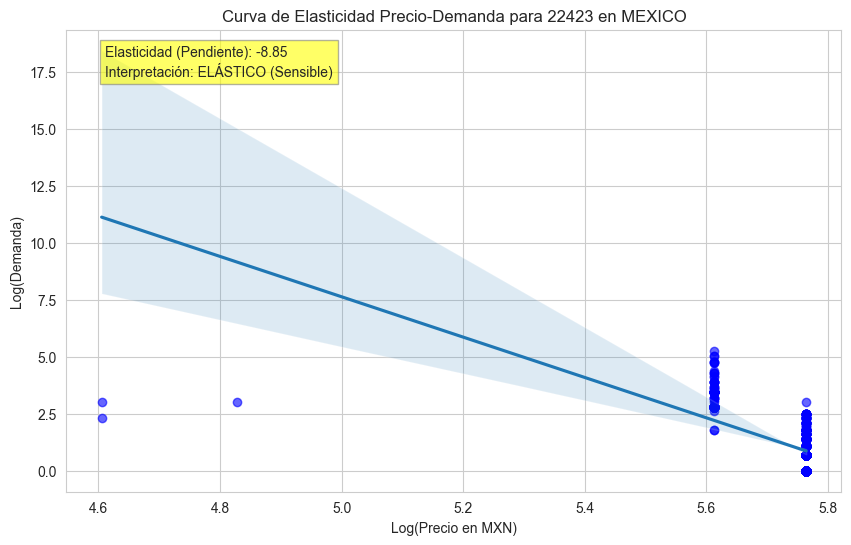

In [4]:
# A. Selección de datos para el análisis OLS (Usar el mismo producto popular que en Fase 2)
TARGET_COUNTRY = 'MEXICO'
# NOTA: Reemplaza '22423' si tu producto más vendido fue otro.
TARGET_STOCK = '22423' 

df_plot = df_master[
    (df_master['Country'] == TARGET_COUNTRY) & 
    (df_master['StockCode'] == TARGET_STOCK) &
    (df_master['Total_Quantity_Sold'] > 0) & 
    (df_master['UnitPrice'] > 0)
].copy()

# B. Transformación Log-Log
df_plot['log_Quantity'] = np.log(df_plot['Total_Quantity_Sold'])
df_plot['log_Price'] = np.log(df_plot['UnitPrice'])

# C. Entrenar el modelo OLS (solo para obtener la línea de regresión)
X = sm.add_constant(df_plot['log_Price'])
Y = df_plot['log_Quantity']
model = sm.OLS(Y, X).fit()
elasticity = model.params['log_Price']

# D. Generación del Gráfico
plt.figure(figsize=(10, 6))
sns.regplot(x='log_Price', y='log_Quantity', data=df_plot, scatter_kws={'alpha':0.6, 'color':'blue'})

plt.title(f'Curva de Elasticidad Precio-Demanda para {TARGET_STOCK} en {TARGET_COUNTRY}')
plt.xlabel(f'Log(Precio en {df_plot["Local_Currency"].iloc[0]})')
plt.ylabel('Log(Demanda)')
plt.text(
    0.05, 0.90, 
    f'Elasticidad (Pendiente): {elasticity:.2f}\nInterpretación: {"ELÁSTICO (Sensible)" if elasticity < -1 else "INELÁSTICO (Oportunidad de Margen)"}', 
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='yellow', alpha=0.6, edgecolor='gray')
)
plt.show()

RMSE (Error de Predicción) replicado: 13.28


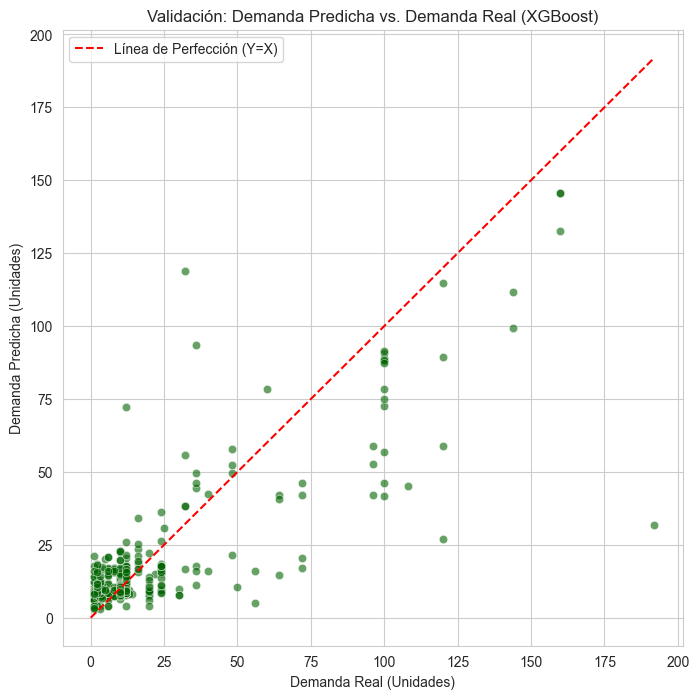

In [6]:
# A. Recrear X_test y Y_test (Debemos replicar el split de la Fase 3)
# 1. Preparación de Variables para XGBoost (igual que en Fase 3)
df_model_full = pd.get_dummies(df_master.drop(columns=['InvoiceDate', 'Local_Currency']), 
                               columns=['StockCode', 'Country'])
X = df_model_full.drop(columns=['Total_Quantity_Sold'])
Y = df_model_full['Total_Quantity_Sold']
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 2. Re-entrenamiento del modelo (Necesario si no está en memoria)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, Y_train)
Y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"RMSE (Error de Predicción) replicado: {rmse:.2f}")

# B. Preparación de datos para la gráfica
sample_size = 500
df_results = pd.DataFrame({
    'Actual': Y_test.head(sample_size).values, 
    'Predicted': Y_pred[:sample_size]
})

# C. Generación del Gráfico
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=df_results, alpha=0.6, color='darkgreen')

# Dibujar la línea de perfección (Y=X)
max_val = df_results[['Actual', 'Predicted']].max().max()
plt.plot([0, max_val], [0, max_val], 'r--', label='Línea de Perfección (Y=X)')

plt.title('Validación: Demanda Predicha vs. Demanda Real (XGBoost)')
plt.xlabel('Demanda Real (Unidades)')
plt.ylabel('Demanda Predicha (Unidades)')
plt.legend()
plt.show()